# AI Lab Run Evaluation
Including hiddim, recon and phonepred. 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
from IPython.display import Audio
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.manifold import TSNE   # one type of clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from itertools import combinations
from sklearn.decomposition import PCA

In [2]:
from model_padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from misc_my_utils import *
from model_loss import *
from model_model import VQVAEV1 as TheLearner
from model_dataset import WordDatasetPath as ThisDataset
from model_dataset import Normalizer, DeNormalizer
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import DS_Tools
from reshandler import DictResHandler
from misc_progress_bar import draw_progress_bar
from test_bnd_detect_tools import *
from misc_tools import PathUtils as PU
from misc_tools import AudioCut, ARPABET

## Preps

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [8]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5
NUM_LAYERS = 2
EMBEDDING_DIM = 128

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Prepare for loading Model

In [9]:
ts = "0219183843"
stop_epoch = "99"
train_name = "B_05"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
assert PU.path_exist(model_save_dir)
print(f"{train_name}-{ts}")

B_05-0219183843


## Load Dataset

In [10]:
TEST = False

In [11]:
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       transform=mytrans)

valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)


# Load Test set
if TEST: 
    test_ds = ThisDataset(rec_dir, 
                        test_guide_path, 
                        transform=mytrans)
    test_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "test.use"))

    use_test_ds = torch.utils.data.Subset(test_ds, test_ds_indices)

    test_loader = DataLoader(use_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
    test_num = len(test_loader.dataset)

## Model

### Model-related defs

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
model = TheLearner(enc_size_list=ENC_SIZE_LIST, 
                   dec_size_list=DEC_SIZE_LIST, 
                   embedding_dim=EMBEDDING_DIM, 
                   num_layers=NUM_LAYERS, dropout=DROPOUT)
# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [13]:
model_name = "{}.pt".format(stop_epoch)
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

VQVAEV1(
  (encoder): VQEncoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (lin_2): Linear(in_features=16, out_features=8, bias=True)
    (act): ReLU()
  )
  (decoder): VQDecoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=2, batch_first=True, dropout=0.5)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_2): Linear(in_features=8, out_features=64, bias=True)
    (act): ReLU()
  )
  (vq_embedding): Embedding(128, 8)
)

## Inference

In [14]:
def infer(): 
    model.eval()
    reshandler = DictResHandler(whole_res_dir=model_save_dir, 
                                 file_prefix="recon-encode")
    all_ze = []
    all_zq = []
    all_name = []
    all_recon = []
    all_ori = []

    for (x, x_lens, name) in tqdm(valid_loader): 
        name = name[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        x_hat, _, (ze, zq) = model(x, x_lens, x_mask)

        ze = ze.cpu().detach().numpy().squeeze()
        zq = zq.cpu().detach().numpy().squeeze()
        
        recon_x = x_hat.cpu().detach().numpy().squeeze()
        ori_x = x.cpu().detach().numpy().squeeze()

        all_ze += [ze]
        all_zq += [zq]
        all_recon += [recon_x]
        all_ori += [ori_x]
        # note that this is bit different, not each frame, but each sequence is treated as one data point
        all_name += [name]
    
    reshandler.res["ze"] = all_ze
    reshandler.res["zq"] = all_zq
    reshandler.res["name"] = all_name
    reshandler.res["recon"] = all_recon
    reshandler.res["ori"] = all_ori
    reshandler.save()

In [15]:
if __name__ == "__main__": 
    infer()

100%|██████████| 31142/31142 [05:37<00:00, 92.15it/s] 


# Load Res

In [16]:
reshandler = DictResHandler(whole_res_dir=model_save_dir, file_prefix="recon-encode")
reshandler.read()

# Recon

In [18]:
# all
all_recon = reshandler.res["recon"]
all_ori = reshandler.res["ori"]
all_name = reshandler.res["name"]

In [19]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

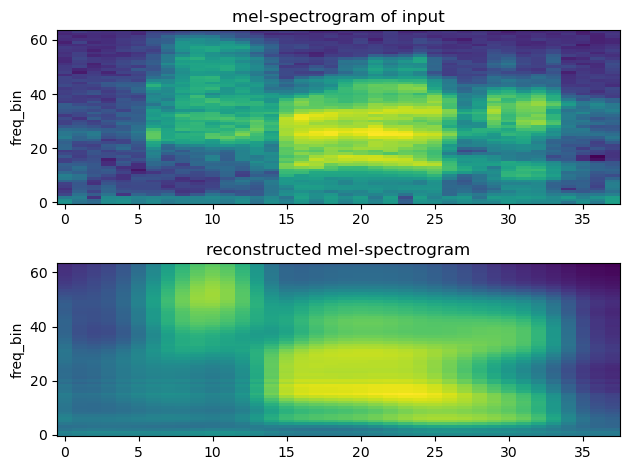

In [32]:
i = random.randint(0, len(all_name))
fig, axs = plt.subplots(2, 1)
plot_spectrogram(all_ori[i].T, title="mel-spectrogram of input", ax=axs[0])
plot_spectrogram(all_recon[i].T, title="reconstructed mel-spectrogram", ax=axs[1])
fig.tight_layout()

# Plot some recon and original comparisons

In [33]:
# all
all_ze = reshandler.res["ze"]
all_zq = reshandler.res["zq"]
all_name = reshandler.res["name"]

# read in guide file
guide_file = pd.read_csv(valid_guide_path)
# filtering out is not necessary, since we only include wuid for encoded words
guide_file = guide_file[~guide_file["segment_nostress"].isin(["sil", "sp", "spn"])]
filtered_df = guide_file[guide_file['wuid'].isin(all_name)].copy()

filtered_df["startFrame"] = filtered_df.apply(lambda x: time_to_frame(x['startTime'] - x['word_startTime']), axis=1)
filtered_df["endFrame"] = filtered_df.apply(lambda x: time_to_frame(x['endTime'] - x['word_startTime']), axis=1)

In [34]:
name_dict = {token: index for index, token in enumerate(all_name)}

In [35]:
def cutHid(hid, cutstart, cutend, start_offset=0, end_offset=1): 
    selstart = max(cutstart, int(cutstart + (cutend - cutstart) * start_offset))
    selend = min(cutend, int(cutstart + (cutend - cutstart) * end_offset))
    # hid is (L, H)
    return hid[selstart:selend, :]

In [36]:
def get_toplot(data, name_dict, df, selector, max_counts=500, offsets=(0, 1)): 
    selected_df = pd.DataFrame(columns=df.columns)
    for item in selector:
        # Filter the DataFrame for the current item
        filtered_df = df[df['segment_nostress'] == item]
        
        # Check if the number of rows exceeds the maximum count
        if len(filtered_df) > max_counts:
            # Randomly sample max_counts[item] rows
            sampled_df = filtered_df.sample(n=max_counts, replace=False)
        else:
            sampled_df = filtered_df
        # Append to the selected_df
        selected_df = pd.concat([selected_df, sampled_df], axis=0)
    # selected_df = df[df["segment_nostress"].isin(cluster_groups)]
    selected_wuid = selected_df["wuid"].tolist()
    indices = [name_dict[token] for token in selected_wuid]
    selected_items = []
    for idx in indices: 
        selected_items.append(data[idx])
    cutstarts = selected_df["startFrame"]
    cutends = selected_df["endFrame"]

    hid_sel = np.empty((0, 8))
    tag_sel = []
    for (item, start, end, tag) in zip(selected_items, cutstarts, cutends, selected_df["segment_nostress"]): 
        hid = cutHid(item, start, end, offsets[0], offsets[1])
        hidlen = hid.shape[0]
        hid_sel = np.concatenate((hid_sel, hid), axis=0)
        tag_sel += [tag] * hidlen
    return hid_sel, np.array(tag_sel)

In [37]:
import pickle
from model_dataset import TokenMap

with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

mymap = TokenMap(mylist)

### Multiplot by Phoneme

(0.0, 0.1)
(0.1, 0.2)
(0.2, 0.30000000000000004)
(0.30000000000000004, 0.4)
(0.4, 0.5)
(0.5, 0.6)
(0.6000000000000001, 0.7000000000000001)
(0.7000000000000001, 0.8)
(0.8, 0.9)
(0.9, 1.0)


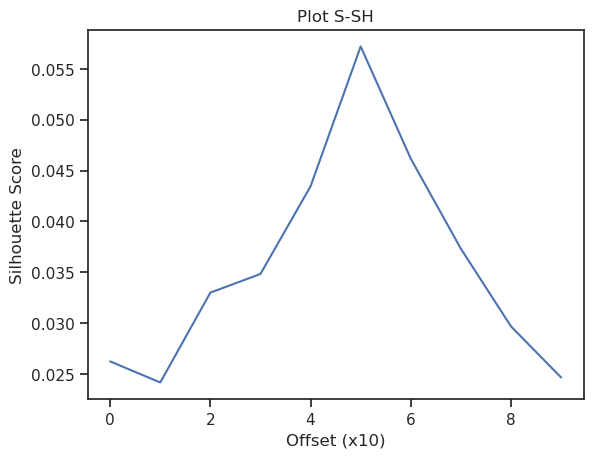

In [50]:
cluster_groups = ["S", "SH"]
sil_list = []
jumper = 0.1
x_range = range(int(1/jumper))

for offset_start_ten in x_range: 
    offsets = (offset_start_ten * jumper, offset_start_ten * jumper + jumper)
    print(offsets)
    # get usable cluster groups
    hidr_cs, tags_cs = get_toplot(data=all_zq, 
                                name_dict=name_dict, 
                                df=filtered_df, 
                                selector=cluster_groups, 
                                max_counts=1000, 
                                offsets=offsets)
    color_translate = {item: idx for idx, item in enumerate(cluster_groups)}
    # Use Counter to count the occurrences of each item
    item_counts = Counter(tags_cs)
    X, Y = hidr_cs, tags_cs
    silhouette_avg = silhouette_score(X, tags_cs)
    sil_list.append(silhouette_avg)

    # pca = PCA(n_components=2)  # Reduce to 2 dimensions
    # pca_result = pca.fit_transform(X)  # Make sure to convert from PyTorch tensor to NumPy array if necessary
    # plt.figure(figsize=(10, 7))  # Larger figure size for better visibility
    # scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.vectorize(mymap.encode)(Y), cmap='viridis', alpha=0.5)
    # plt.colorbar(scatter)
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.title('PCA of Hidden Representations Colored by Ground Truth Labels')
    # plt.show()

plt.plot(x_range, sil_list) # Plot the points
plt.title(f'Plot {"-".join(cluster_groups)}')
plt.xlabel('Offset (x10)')
plt.ylabel('Silhouette Score')
plt.show()


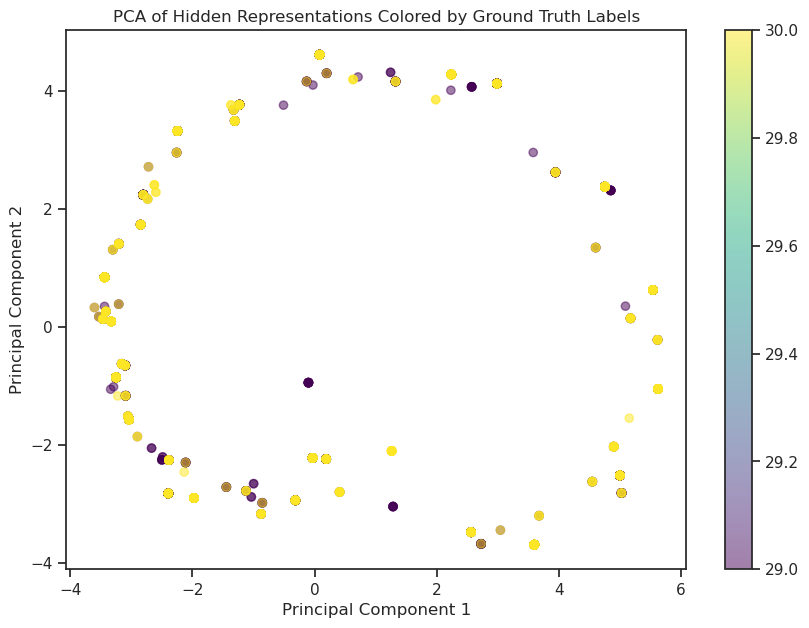

In [51]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_result = pca.fit_transform(X)  # Make sure to convert from PyTorch tensor to NumPy array if necessary

# Create a scatter plot colored by the ground truth labels
plt.figure(figsize=(10, 7))  # Larger figure size for better visibility
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.vectorize(mymap.encode)(Y), cmap='viridis', alpha=0.5)

# Add a color bar to show the correspondence between color and class
plt.colorbar(scatter)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Hidden Representations Colored by Ground Truth Labels')
plt.show()

In [52]:
# Number of clusters
n_clusters = len(cluster_groups)

# Running KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X)


In [53]:
silhouette_avg = silhouette_score(X, tags_cs)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.024649025942165125


In [54]:
adjusted_rand_score(tags_cs, cluster_labels)

7.287716610409862e-05

In [55]:
v_measure_score(tags_cs, cluster_labels)

0.00020538360484047925

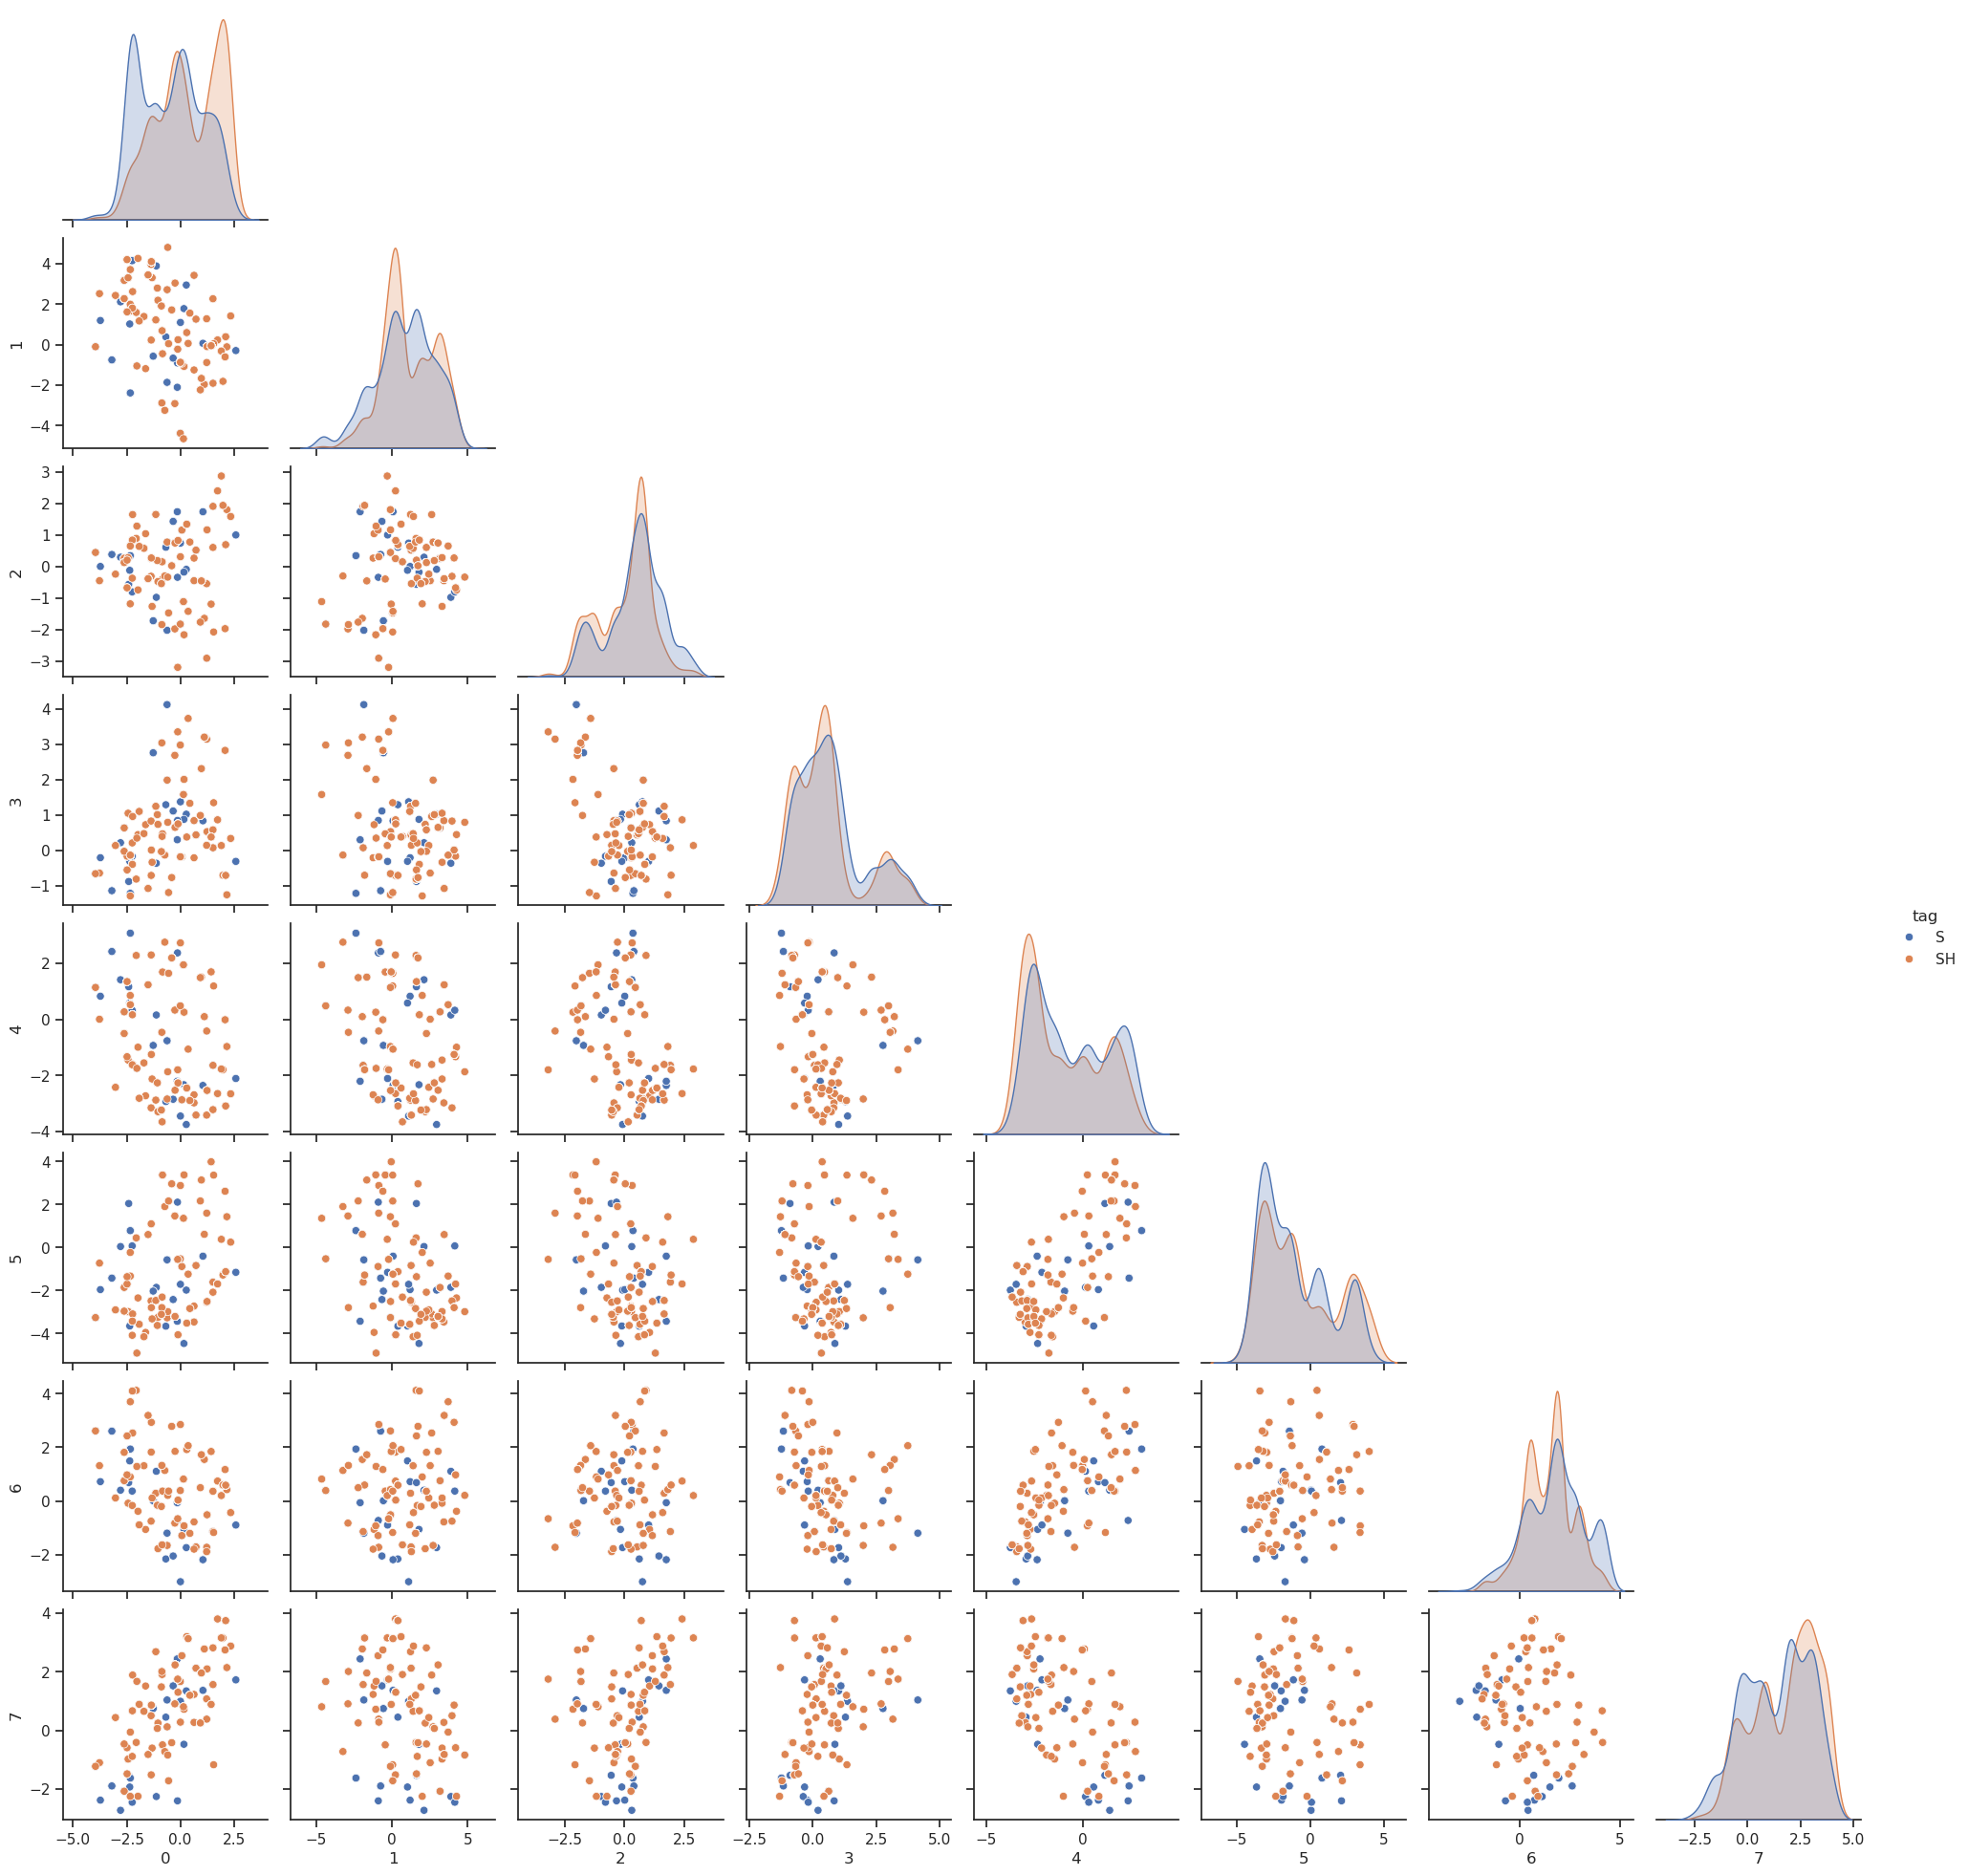

In [56]:
X = hidr_cs
y = tags_cs

colors = [color_translate[item] for item in y]
df = pd.DataFrame(X)
df["tag"] = y

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df,hue='tag', corner=True, diag_kind="kde")
# g.map_lower(sns.kdeplot, levels=4, color=".2")

## Corr

In [57]:
def dataframe_to_phonological_dict(df):
    phonological_dict = {}
    for index, row in df.iterrows():
        symbol = row['ARPABET']
        phonological_vector = np.array(row.iloc[3:], dtype=int)
        phonological_dict[symbol] = phonological_vector
    return phonological_dict

In [58]:
def edit_dist(a, b): 
    # a, b being numpy arrays
    return np.sum(a != b)

In [59]:
mapper = pd.read_csv("./english_to_feats.csv")
mapper = mapper[mapper["ARPABET"].notna()]

In [60]:
mapperdict = dataframe_to_phonological_dict(mapper)

In [61]:
all_v = filtered_df[filtered_df["segment_nostress"].isin(ARPABET.list_vowels())]["segment_nostress"].unique().tolist()
all_c = filtered_df[filtered_df["segment_nostress"].isin(ARPABET.list_consonants())]["segment_nostress"].unique().tolist()

In [62]:
len(list(combinations(all_c, 2)))

276

In [63]:
ssc = [] # silhouette score
eds = []

for (a, b) in list(combinations(all_v, 2)): 
    X, Y = get_toplot(data=all_zq, 
                              name_dict=name_dict, 
                              df=filtered_df, 
                              selector=[a, b], 
                              max_counts=500)
    
    ssc.append(silhouette_score(X, Y))
    eds.append(edit_dist(mapperdict[a], mapperdict[b]))

In [64]:
correlation_matrix = np.corrcoef(ssc, eds)
correlation = correlation_matrix[0, 1]
print(f"Pearson's correlation coefficient: {correlation}")


Pearson's correlation coefficient: 0.1938192358866882


In [65]:
alltoken_out = pd.DataFrame({"edit_dist": eds, "silhouette": ssc})

<Axes: xlabel='edit_dist', ylabel='silhouette'>

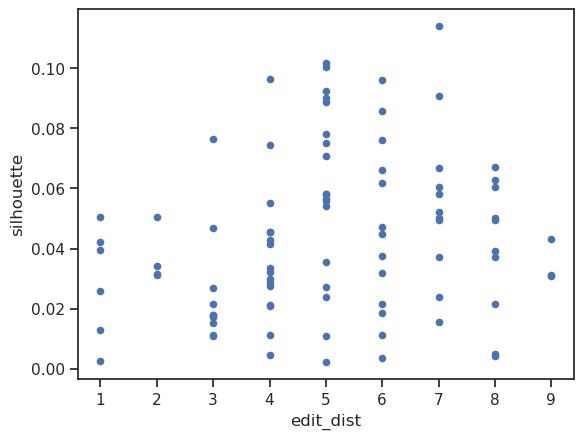

In [66]:
alltoken_out.plot(x='edit_dist', y='silhouette', kind='scatter')

In [67]:
alltoken_out[["edit_dist", "silhouette"]].corr()

,edit_dist,silhouette
edit_dist,1.000000,0.193819
silhouette,0.193819,1.000000


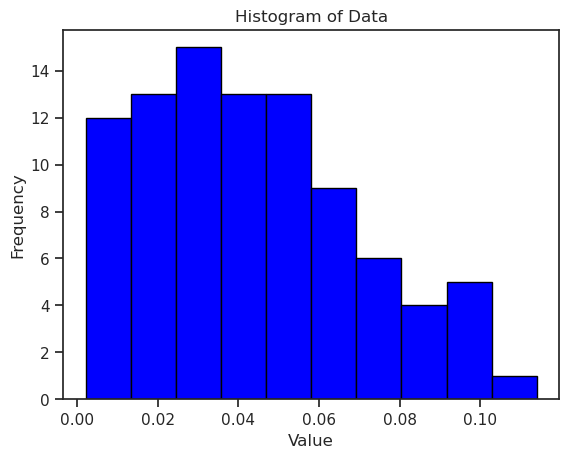

In [68]:
# Creating the histogram
plt.hist(ssc, bins=10, color='blue', edgecolor='black')  # You can adjust the number of bins

# Adding titles and labels
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [69]:
np.array(ssc).mean()

0.04390793542492445

# Attention check

## Inference

In [75]:
def infer(): 
    model.eval()
    reshandler = DictResHandler(whole_res_dir=model_save_dir, 
                                 file_prefix="attention")
    all_attn = []
    all_name = []

    for (x, x_lens, name) in tqdm(valid_loader): 
        name = name[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)

        attn_w = attn_w.cpu().detach().numpy().squeeze()

        all_attn += [attn_w]
        # note that this is bit different, not each frame, but each sequence is treated as one data point
        all_name += [name]
    
    # reshandler.res["ze"] = all_ze
    # reshandler.res["zq"] = all_zq
    # reshandler.res["name"] = all_name
    # reshandler.res["recon"] = all_recon
    # reshandler.res["ori"] = all_ori
    reshandler.res["attn"] = all_attn
    reshandler.res["name"] = all_name
    reshandler.save()

In [76]:
if __name__ == "__main__": 
    infer()

100%|██████████| 31142/31142 [05:04<00:00, 102.19it/s]


# Load Res

In [77]:
reshandler = DictResHandler(whole_res_dir=model_save_dir, file_prefix="attention")
reshandler.read()

In [80]:
all_attn = reshandler.res["attn"]
all_name = reshandler.res["name"]

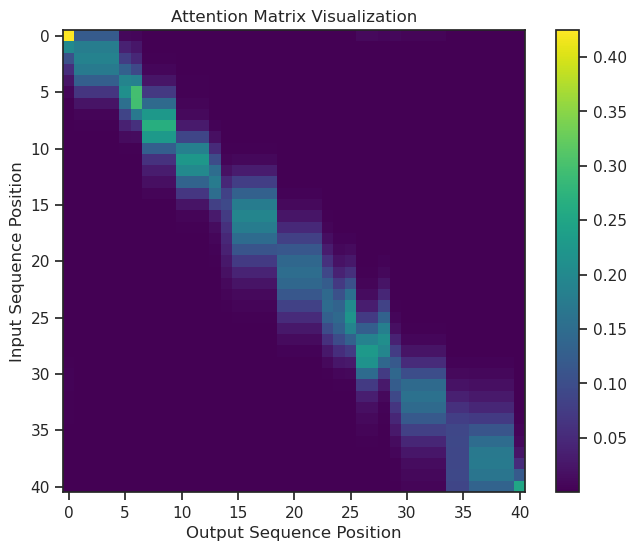

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'attention_matrix' is a numpy array of shape (len, len)
# For demonstration, let's create a sample attention matrix
i = random.randint(0, len(all_name))
attention_matrix = all_attn[i]

# Plotting the attention matrix
plt.figure(figsize=(8, 6))
plt.imshow(attention_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Attention Matrix Visualization')
plt.xlabel('Output Sequence Position')
plt.ylabel('Input Sequence Position')
plt.show()
